In [1]:
%matplotlib inline
# useful additional packages

#import math tools
import numpy as np

# general Graphs tools
import networkx as nx

# more plotting tools
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# to make images look nicer
%config InLineBackend.figure_format = 'svg' 

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram


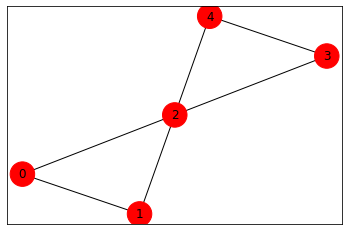

In [2]:
# Generating the butterly graph with 5 nodes

n = 5
V = np.arange(0, n, 1)
E = [(0,1,1.0), (0,2,1.0), (1,2,1.0), (3,2,1.0), (3,4,1.0), (4,2,1.0)]
G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

#generate plot of the Graph
colors = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos = nx.spring_layout(G)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)


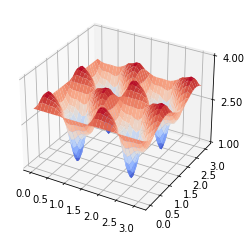


 --- Optimal Parameters 

The maxima expectation value is: M1 = 3.431
This is attained for gamma = 1.900 and beta = 0.200


In [3]:
# p = 1
# one layer of gates ?
# We can get expectation value for edges?
# A = {(0,1), (3,4)} 
# B = {(0,2),(1,2),(2,3),(2,4)}
# A has only two neighboring edges
# B has four neighboring edges
# somehow if you calculate for one edge in the set,
# it would be the same for all other edges in that set
# Compute F1 which is 2fA + 4fB ? 

# some ridiculous formla for 2fA
# same for 4fB
# It can be more ridiculous depending on the degree of the graph.
# It is nice that it is independed on the size though, just degree.
# now combining 2fA and 4fB we get ridiculous formula for F1
# okay

# Evaluate the function
step_size = 0.1

a_gamma = np.arange(0, np.pi, step_size)
a_beta = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma, a_beta)

F1 = 3-(np.sin(2*a_beta)**2*np.sin(2*a_gamma)**2-
    0.5*np.sin(4*a_beta)*np.sin(4*a_gamma)) * (1+np.cos(4*a_gamma)**2)

# Grid search for the minimizing variables
result = np.where(F1 == np.amax(F1))
a = list(zip(result[0], result[1]))[0]

gamma = a[0]*step_size;
beta = a[1]*step_size;

# Plot the expectation value F1
fig = plt.figure()
ax = fig.gca(projection = '3d')

surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(1,4)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

# the smallest parameters and the expectation cn be extracted
print('\n --- Optimal Parameters \n')
print('The maxima expectation value is: M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))

# something happened? so what?

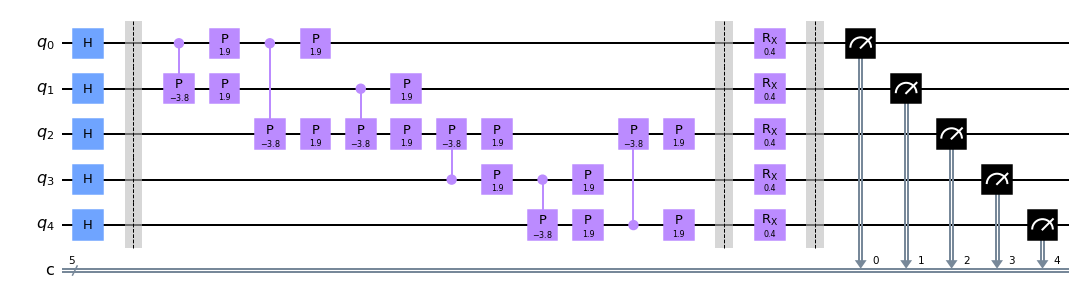

In [4]:
# now we can use these numbers above? to construct the circuit
# B = sum(X)
# H = sum(1-ZZ)
# 1) do Hadamard to get + states
# 2) some kind of Ising gates U(gamma)
# 3) Apply X gates
# 4) Measure in Z?

# prepare the quantum and classical registers
QAOA = QuantumCircuit(len(V), len(V))

# apply the layer of Hadamard gates to all qubits
QAOA.h(range(len(V)))
QAOA.barrier()

# apply the Ising type gates with the angle gamma along the edges in E
for edge in E:
    k = edge[0]
    l = edge[1]
    QAOA.cp(-2*gamma, k, l)
    QAOA.p(gamma, k)
    QAOA.p(gamma, l)
    

# then apply the single qubit X rotations with angle beta to all qubits
QAOA.barrier()
QAOA.rx(2 * beta, range(len(V)))

# Finally measure the result in the computational basis
QAOA.barrier()
QAOA.measure(range(len(V)), range(len(V)))

# draw the circuit 
QAOA.draw('mpl')



In [5]:
# now that we have some lol circuit we should think of a way to 
# evaluating it's cost?
# that should tell us if we measured anything that makes sense
# find a good candidate

# Compute the value of the cost function
def cost_function_C(x, G):
    E = G.edges()
    if (len(x) != len(G.nodes())):
        return np.nan
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        w = G[e1][e2]['weight'] # this is nice adding the weight
        #they are all 1's but could be changed I presume
        C = C + w*x[e1]*(1-x[e2])+w*x[e2]*(1-x[e1])
    return C
# but why this form?
# ok in the text it says in binary combinatorial optimization
# problems, the cost C function has a form of 
# sum(w*xi*(1-xj))

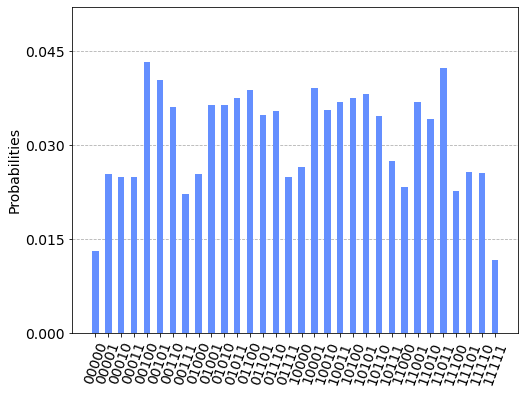

In [6]:
# run on the simulator and let's see

backend = Aer.get_backend("qasm_simulator")
shots = 10000
simulate = execute(QAOA, backend = backend, shots = shots)
QAOA_results = simulate.result()
plot_histogram(QAOA_results.get_counts(), figsize = (8, 6), bar_labels = False)



 --- SIMULATION RESULTS --- 

The sampled mean value is M1_sampled = 3.30 while the true alue is M1 = 3.43 

The approximate solution is x* = 10001 with C(x*) = 4 

The cost function is distributed as: 



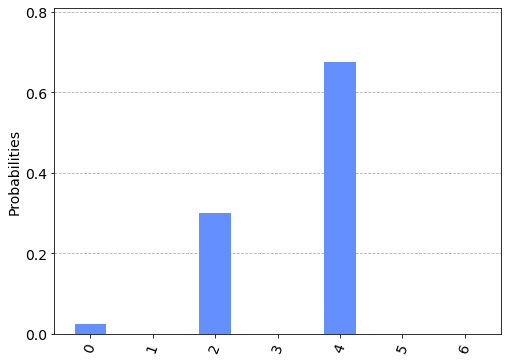

In [7]:
# now that we run and measured our circuit we evaluate cost?

# 1) Compute mean energy ?
# 2) find which string has larges cost C?
# 3) check energies? plot

# Evaluate the date from the siulator
counts = QAOA_results.get_counts()

avr_C = 0
max_C = [0,0]
hist = {}

for k in range(len(G.edges()) + 1):
    hist[str(k)] = hist.get(str(k), 0)
    
for sample in list(counts.keys()):
    # use sampled bit string x to compute C(x)
    x = [int(num) for num in list(sample)]
    tmp_eng = cost_function_C(x, G)
    
    # compute the expectation value and energy distribution
    avr_C = avr_C + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)), 0) + counts[sample]
    
    # save best bit string
    if (max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
#
M1_sampled = avr_C / shots

print('\n --- SIMULATION RESULTS --- \n')
print('The sampled mean value is M1_sampled = %.02f while the true alue is M1 = %.02f \n' % (M1_sampled, np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0], max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist, figsize = (8, 6), bar_labels = False)

In [8]:
# okay I didn't get anything, but let's run on real device

# Use the IBMQ essex device
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 5 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
shots   = 2048

job_exp = execute(QAOA, backend=backend, shots=shots)
job_monitor(job_exp)

/home/note/.local/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


Job Status: job has successfully run


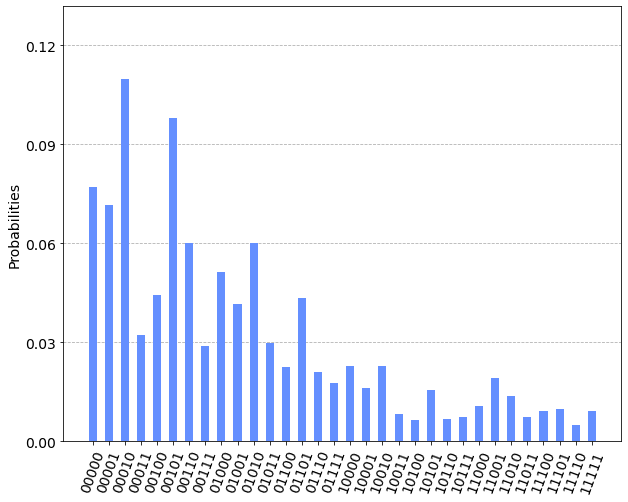

In [11]:
exp_results = job_exp.result()
plot_histogram(exp_results.get_counts(),figsize = (10,8), bar_labels = False)


 --- EXPERIMENTAL RESULTS ---

The sampled mean value is  M1_sampled = 2.90 while the true value is M1 = 3.43 

The approximate solution is x* = 10001 with C(x*) = 4 

The cost function is distributed as: 



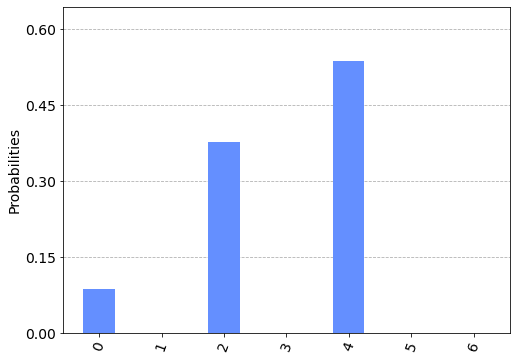

In [15]:
# okay so I didn't get results fast, queue is too long :(
# but I shall continue my guess

#Evaluate the data from the experiment
counts = exp_results.get_counts()
avr_C = 0
max_C = [0, 0]
hist = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)
    
for sample in list(counts.keys()):
    # use sampled bit string x to compute C(x)
    
    x =  [int(num) for num in list(sample)]
    tmp_eng = cost_function_C(x, G)
    
    # compute the expectation value and energy distribution)
    avr_C = avr_C + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if (max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
        
M1_sampled = avr_C/shots


print('\n --- EXPERIMENTAL RESULTS ---\n')
print('The sampled mean value is  M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0], max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist, figsize = (8, 6), bar_labels = False)


In [17]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.2',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.2'}